## SIR-X model


The SIR-X model http://rocs.hu-berlin.de/corona/docs/forecast/results_by_country/ is a simple but seems to be accurate model.

The population is described by **S** (fraction of people suspectible to the infection), **I** (fraction of people infected and spreading the infection), (**R** which is neither suspectible nor infected), and **X** (the number of "quarantineed" people). 

$X$ is roughly the number of cases reported by each country. 

The equations describing the evolution of $S$, $I$, $R$ and $X$ are self-explanatory:

$$\frac{dS}{dt} = -\alpha S I - k_0 S,  \quad \frac{dI}{dt} = \alpha S I - \beta I - k_0 I - k I, 
\quad \frac{dX}{dt} = (k_0 + k) I, \quad \frac{dR}{dt} = k_0 S + \beta I.$$

The first equation controls the spread of the infection (the growth is proportional to the probability of meeting of $S$ and $I$), 
the constant $\beta$ controls the recovery / death process (and is roughly $\beta \approx \frac{1}{T}$, where $T$ is the characteristic time of the decease). 

The parameters $k_0$ and $k$ represent the measures taken: $k_0$ corresponds to social distancing / contract tracing, whereas $k$ controls the quarantine process for symptomatic individuals

To fit the model, one has to find the parameters of it $\alpha, \beta, k_0, k$ and the initial number of infected individuals $I_0$ such that the $X(t)$ approximates the observed cases $C(t)$. The true number of potentially infected people $I(t)$ can be much larger. 

Several optimization techniques can be used. We tried gradient-free optimization package **nevergrad**, however, 
right now we are doing the Bayesian optimization in order to give not only the values of parameters, but also the risk values. 


The data collection below is taken form a nice [Google Colab notebook](https://colab.research.google.com/drive/15R6bXKW--TSMXClMfHql8zU0ePOLEoa3)

In [1]:
Country = 'Denmark'
population = {"Russia" : 146745098, 
              "Italy" : 60317000, 
              "China" : 1404328000, 
              "US" : 331002651, 
              "Korea, South":  51259070,
              "Denmark" : 5792202
             }

starting_threshold = 10
search_attempts = 1000



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
#import pymc as pm
from scipy.integrate import odeint
from concurrent import futures

%matplotlib inline


In [3]:
online = True

if online:
    COVID_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
else:
    COVID_CONFIRMED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    


covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)
covid_deaths = pd.read_csv(COVID_DEATHS_URL)
covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

covid_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_confirmed.rename(columns={'Province/State':'State'}, inplace=True)
covid_deaths.rename(columns={'Province/State':'State'}, inplace=True)
covid_recovered.rename(columns={'Province/State':'State'}, inplace=True)

covid_confirmed = covid_confirmed.groupby("Country").sum()
covid_deaths = covid_deaths.groupby("Country").sum()
covid_recovered = covid_recovered.groupby("Country").sum()


covid_confirmed.sort_values(covid_confirmed.columns[-1]).tail()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
Country,,,,,,,,,,,,,,,,,,,,,
Germany,51.0000,9.0000,0,0,0,0,0,1,4,4,...,71808,77872,84794,91159,96092,100123,103374,107663,113296,118181
France,91.3624,59.7192,0,0,2,3,3,3,4,5,...,52827,57749,59929,65202,90848,93773,98963,110065,113959,118781
Italy,43.0000,12.0000,0,0,0,0,0,0,0,0,...,105792,110574,115242,119827,124632,128948,132547,135586,139422,143626
Spain,40.0000,-4.0000,0,0,0,0,0,0,0,0,...,95923,104118,112065,119199,126168,131646,136675,141942,148220,153222
US,37.0902,-95.7129,1,1,2,2,5,5,5,5,...,188172,213372,243762,275586,308853,337072,366667,396223,429052,461437


In [4]:
data_country_confirmed = covid_confirmed.loc[Country].values[2:].astype(int)

data = np.empty((3, data_country_confirmed.shape[0]), dtype=np.int64)
data[0] = data_country_confirmed

data[1] = covid_deaths.loc[Country].values[2:].astype(int)
data[2] = covid_recovered.loc[Country].values[2:].astype(int)

data_normed = data.astype(np.float64) / population[Country]
data_normed_only_conf = data_normed[0] - data_normed[1] - data_normed[2]

data[0][-1]

5830

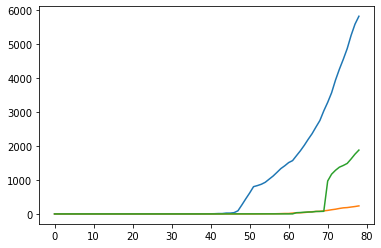

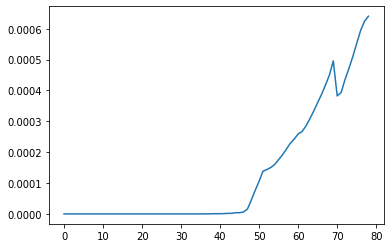

In [5]:
plt.plot(data.T);
plt.figure()
plt.plot(data_normed_only_conf);

In [6]:
@jit
def base_seir_model(init_vals, dt, N, params):
    res = np.empty((N, 4), dtype=np.float64)
    S = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    #print(I)
    return res


def seir_rhs(y, t, alpha, beta, gamma):
    S, E, I, R = y
    return [-beta*S*I, beta*S*I - alpha*E, alpha*E - gamma*I, gamma*I]

def base_seir_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(seir_rhs, init_vals, t, args=params)
    #return sol[::int(1/dt)]
    return sol

@jit
def sirx_rhs(x, t, alpha, beta, k0, k):
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = (alpha*S - beta - (k0 + k))*I
    dxdt = (k0 + k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])


def base_sirx_model_rhs(x, params):
    alpha, beta, k0, k = params
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = alpha*S*I - beta*I - k0*I - k*I
    dxdt = (k0+k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])

#@jit
def base_sirx_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(sirx_rhs, init_vals, t, args=params)
    #sol[np.isnan(sol)] = 1e20
    #sol[np.isinf(sol)] = 1e20
    return sol



# SIR Model (not working)
@jit
def base_sirf_model(init_vals, dt, N, params):
    res = np.empty((N, 3), dtype=np.float64)
    y = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    return res


In [7]:
#vals = []

data1 = data[0]
data1 = data1[data1>=starting_threshold]
data_offset = 0
# data_offset = np.argwhere(data1 > 100)[0][0]

print(data_offset)
# data1 = data1/population[Country]
#plt.plot(data1)

#true_cases = data_normed_only_conf[-20:]
#true_cases = data_normed_only_conf[data[0] >= 3]
#true_cases = data_normed[0][data[0] >= 3]
true_cases = data1/population[Country]


def obs(alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, cf = 1, N = len(true_cases), type_ret=2):
        # N is number of points (days)
        #global vals
        dt = 1.0/cf
        num = (N-1)*cf
        # res = base_sirx_model_odeint((1.0 - (I0_MC + true_cases[0]), I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        res = base_sirx_model_odeint((1.0 - I0_MC, I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[type_ret][::cf]
        #print(rr)
        #vals.append(rr)
        return rr
    
def obs2(alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, cf = 1, N = len(true_cases)):
        # N is number of points (days)
        #global vals
        dt = 1.0/cf
        num = (N-1)*cf
        # res = base_sirx_model_odeint((1.0 - (I0_MC + true_cases[0]), I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        res = base_sirx_model_odeint((1.0 - I0_MC, I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[::cf]
        #print(rr)
        #vals.append(rr)
        return rr

    

def loss_fn_weighted(alpha, beta, k0, k, I0):
    # Weighted variance
    loss_val = np.linalg.norm( (obs(alpha, beta, k0, k, I0)[data_offset:] - true_cases[data_offset:])*data1[data_offset:] )
    return loss_val

def loss_fn_equal_weight(alpha, beta, k0, k, I0):
    # Equal weight variance
    loss_val = np.linalg.norm(obs(alpha, beta, k0, k, I0)[data_offset:] - true_cases[data_offset:])
    return loss_val

_ = """
num_days = len(true_cases)-1
times = np.linspace(0, num_days, num_days+1)

def compute_fit(alpha, beta, k0, k, I0):
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    predicted_cases = sol[:, 2]
    return np.linalg.norm(true_cases-predicted_cases)


def predict(alpha, beta, I0, k0, k, num_days):
    times = np.linspace(0, num_days, num_days+1)
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    return sol

"""

0


In [8]:
def show_match(vals, new_figure=True, label='Predicted'):
    alpha_g, beta_g, k0_g, k_g, I0_g = vals
    num = len(true_cases)+3
    solution = population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=num, cf=1)

    time_scale = np.linspace(1, num, num)
    time_scale_true = np.linspace(1, len(true_cases), len(true_cases))
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.legend();
        plt.title('Match between predicted and actual cases');
        plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
    plt.plot(time_scale, solution, "-", label=label);
    # plt.yscale('log')
    for i in (3,2,1):
        print("{}: day {}: number of cases:{:.0f}".format(label, 4-i, solution[-i] - solution[-i-1]))
        
def present_solution_many(vals, num_days=120, new_figure=True, label_prefix=None):
    alpha_g, beta_g, k0_g, k_g, I0_g = vals
    solution = population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=num_days, cf=1)
    # print(f"{label}: Max cases: {max(solution):.0f}")
    if label_prefix is None:
        label_prefix = ""

    cases_max = solution[-1]/1000
    label = label_prefix + f"{cases_max:6.1f}"
    time_scale = np.linspace(-len(true_cases)+1, num_days - len(true_cases), num_days)
    time_scale_true = np.linspace(-len(true_cases)+1 , -1, len(true_cases))
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.legend();
        plt.title(Country + ': Reported cases model');
        plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
    plt.plot(time_scale, solution, "-", label=label);
    plt.text(time_scale[-10], solution[-1], label)
    # plt.yscale('log')

def present_solution(vals, num_days=120, new_figure=True, label="Predicted"):
    alpha_g, beta_g, k0_g, k_g, I0_g = vals
    solution = population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=num_days, cf=1)
    print(f"{label}: Max cases: {max(solution):.0f}")

    time_scale = np.linspace(-len(true_cases)+1, num_days - len(true_cases), num_days)
    time_scale_true = np.linspace(-len(true_cases)+1 , -1, len(true_cases))
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.legend();
        plt.title(Country + ': Reported cases model');
        plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
    plt.plot(time_scale, solution, "-", label=label);
    plt.text(time_scale[-10], solution[-1], label)
    # plt.yscale('log')


def prognosis(vals, num_days = 120, new_figure=True, several_scenarios=True, label_prefix=None):
    alpha_g, beta_g, k0_g, k_g, I0_g = vals
    start = obs2(alpha_g, beta_g, k0_g, k_g, I0_g, N=len(true_cases))[:, -1]
    dt = 1.0
    res1 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, beta_g, k0_g, k_g))
    if several_scenarios:
        res2 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, beta_g, 1e-2, k_g))
        res3 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, beta_g, 1e-1, k_g))
    
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.title(Country + ': Potentially infected model')
        plt.legend()
    if label_prefix is not None: 
        label_prefix += ": "
    else:
        label_prefix = ''
    plt.plot(res1[:, 1]*population[Country], label=f'{label_prefix}Current measures')
    if several_scenarios:
        plt.plot(res2[:, 1]*population[Country], label=f'{label_prefix}1% strictly isolated')
        plt.plot(res3[:, 1]*population[Country], label=f'{label_prefix}10% strictly isolated')
    print(f"{label_prefix}Infected now: {res1[0, 1]*population[Country]:.0f}")
    if several_scenarios:
        print(f"{label_prefix}Max infected: {max(res1[:, 1]*population[Country]):.0f} vs {max(res2[:, 1]*population[Country]):.0f} vs {max(res3[:, 1]*population[Country]):.0f}")
    else:
        print(f"{label_prefix}Max infected: {max(res1[:, 1]*population[Country]):.0f}")

def prognosis_many(vals, num_days = 120, label_prefix=None, new_figure=True):
    alpha_g, beta_g, k0_g, k_g, I0_g = vals
    start = obs2(alpha_g, beta_g, k0_g, k_g, I0_g, N=len(true_cases))[:, -1]
    dt = 1.0
    res1 = base_sirx_model_odeint(start, dt, num_days, (alpha_g, beta_g, k0_g, k_g))
    
    if new_figure:
        plt.figure(figsize=(10, 8))
        plt.title(Country + ': Potentially infected model')
        plt.legend()
    if label_prefix is not None: 
        label_prefix += ": "
    else:
        label_prefix = ''
    
    solution = res1[:, 1]*population[Country]/1000.0
    infected_now = solution[0]
    infected_max = max(solution)
    infected_max_x = np.argmax(solution)
    
    label = f"{label_prefix}{infected_now:0.1f}, max {infected_max:0.1f}"
    plt.plot(res1[:, 1]*population[Country], label=label)
    plt.text(infected_max_x, infected_max*1000.0, label_prefix)

Trying to optimize the solution using gradient descent in the small vicinity

In [9]:
bounds = ((0.0, 10.0), (5e-2, 2.0), (0.0, 1e-1), (0, 0.1), (true_cases[0], true_cases[0]*100))
bounds_low = np.array([b[0] for b in bounds])
bounds_high = np.array([b[1] for b in bounds])

def cost_fn(x):    
    for v,b in zip(x,bounds):
        l,r = b
        if v < l or v > r:
            return 1e100
    return loss_fn_weighted(*x)

In [10]:
from scipy import optimize

In [11]:
class VectorIterator:
    def __init__(self, N, low = -1, high = 1):
        self.vector = np.full(N, low)
        self.low = low
        self.high = high
    def __iter__(self):
        self.first = True
        return self
    def __next__(self):
        if self.first:
            self.first = False
            return self.vector
            
        for i,x in enumerate(self.vector):
            if x == self.high:
                self.vector[i] = self.low
            else:
                self.vector[i] += 1
                return self.vector
        raise StopIteration

In [12]:
_local_minimum_factor = 1e-2
def is_local_minimum(fn, x):
    step = x*_local_minimum_factor
    vi = VectorIterator(len(x))
    m = fn(x)
    for v in vi:
        y = x + v*step
        val_y = fn(y)
        if val_y < m:
            return False, (y, val_y)
    return True, None

In [13]:
def simple_descend(start, iters = 2000):
    v = start
    for i in range(iters):
        res, nxt = is_local_minimum(cost_fn, v)
        if res:
            print(f"Local minimum on step {i}")
            break
        else:
            v = nxt[0]
    return v

In [14]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [15]:
import itertools

In [16]:
random_search_results = []
for i in range(search_attempts):
    if 0 == i%10:
        update_progress(i/search_attempts)
    x = np.random.uniform(bounds_low, bounds_high)
    opt = optimize.minimize(cost_fn, x, method='Nelder-Mead')
    if not opt.success:
        continue
    random_search_results.append((opt.fun, opt.x))
update_progress(1)

Progress: [####################] 100.0%


In [17]:
random_search_results = sorted(random_search_results, key=lambda v: v[0])
filtered_results = filter(lambda res: res[1][4] < bounds[-1][1], random_search_results)
best = list(itertools.islice(filtered_results, 10))
for i,(f,(a,b,k0,k,i0)) in enumerate(best):
    print(f"{i+1}: R0 = {a/b}, initial infected: {i0*population[Country]:.0f}, number isolated: {k0*100:.2f}%,\n  {f}: {(a,b,k0,k,i0)}\n")

1: R0 = 1.0989049050505753, initial infected: 1000, number isolated: 0.00%,
  0.20795526488032975: (1.2950860670582114, 1.1785242390911042, 4.295089998887219e-09, 0.0351651028061231, 0.00017259667802101082)

2: R0 = 1.0876799549788967, initial infected: 519, number isolated: 0.00%,
  0.2082057430427149: (1.8527736400159014, 1.703418024332212, 1.064578796720939e-07, 0.06634195493006435, 8.9539010128412e-05)

3: R0 = 1.0979645080222844, initial infected: 643, number isolated: 0.00%,
  0.20824778550115083: (1.5147842185849605, 1.3796294939564806, 2.6381439004730533e-07, 0.05665545708387615, 0.00011103549548626096)

4: R0 = 1.1069890689299142, initial infected: 993, number isolated: 0.00%,
  0.20858493380372065: (1.1982548206182226, 1.0824450342373586, 4.8647143350453575e-05, 0.036355619910995826, 0.00017146401737095772)

5: R0 = 1.1028114568521923, initial infected: 683, number isolated: 0.01%,
  0.20879431160524742: (1.4229238134348348, 1.2902693425913025, 7.057793229206581e-05, 0.052682

No handles with labels found to put in legend.


1: day 1: number of cases:379
1: day 2: number of cases:391
1: day 3: number of cases:401
2: day 1: number of cases:375
2: day 2: number of cases:385
2: day 3: number of cases:395
3: day 1: number of cases:385
3: day 2: number of cases:399
3: day 3: number of cases:412
4: day 1: number of cases:386
4: day 2: number of cases:399
4: day 3: number of cases:412
5: day 1: number of cases:386
5: day 2: number of cases:399
5: day 3: number of cases:412
6: day 1: number of cases:387
6: day 2: number of cases:401
6: day 3: number of cases:415
7: day 1: number of cases:386
7: day 2: number of cases:400
7: day 3: number of cases:413
8: day 1: number of cases:385
8: day 2: number of cases:400
8: day 3: number of cases:413
9: day 1: number of cases:386
9: day 2: number of cases:400
9: day 3: number of cases:414
10: day 1: number of cases:390
10: day 2: number of cases:406
10: day 3: number of cases:421


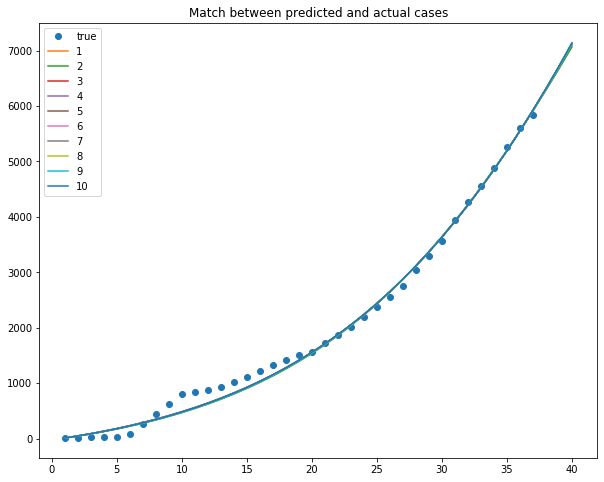

In [18]:
new_figure = True
for i,(f,x) in enumerate(best):
    show_match(x, new_figure=new_figure, label=f"{i+1}")
    new_figure = False
plt.legend()
        

No handles with labels found to put in legend.


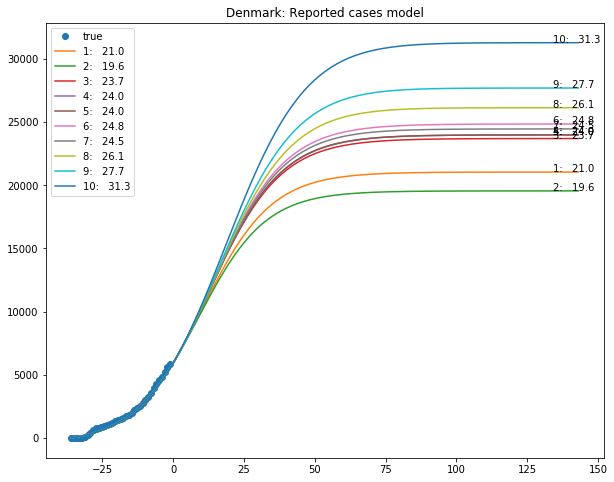

In [19]:
new_figure = True
for i,(f,x) in enumerate(best):
    present_solution_many(x, new_figure=new_figure, num_days=180, label_prefix=f"{i+1}: ")
    new_figure = False
plt.legend()

No handles with labels found to put in legend.


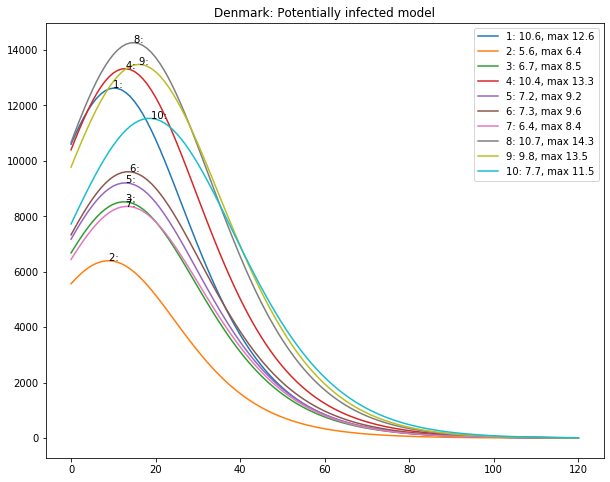

In [20]:
new_figure = True
for i,(f,x) in enumerate(best):
    prognosis_many(x, new_figure=new_figure, label_prefix=f"{i+1}")
    new_figure = False
plt.legend()

In [21]:
vals5 = best[0][1]

No handles with labels found to put in legend.


Infected now: 10599
Max infected: 12624 vs 10773 vs 10599


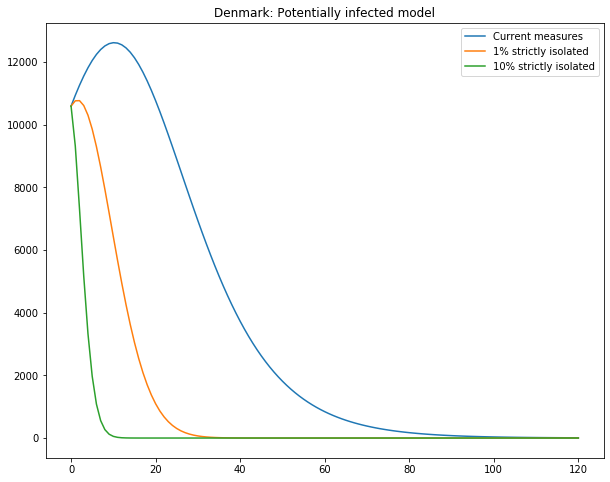

In [22]:
prognosis(vals5)
plt.legend()

In [23]:
tmp_best = best[1][1]

In [24]:
_local_minimum_factor = 1e-4
if not is_local_minimum(cost_fn, tmp_best)[0]:
    tmp_best = simple_descend(tmp_best, 1000)

No handles with labels found to put in legend.


Infected now: 5566
Max infected: 6398 vs 5624 vs 5566


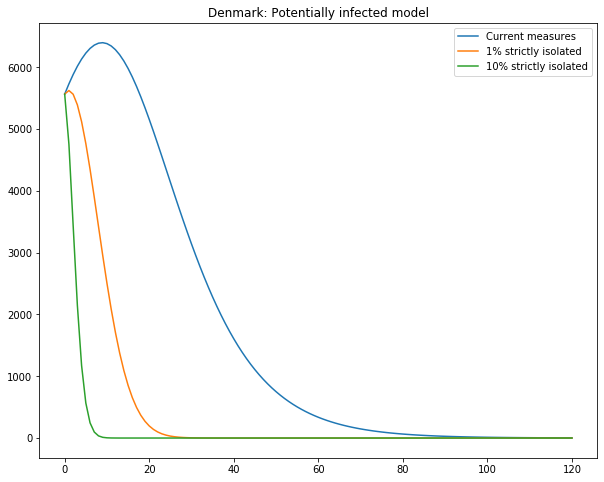

In [25]:
prognosis(tmp_best)
plt.legend()